(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

open yelp_academic_dataset_review.json
DEBUG: 	done

pred: Counter({4.0: 971218, 5: 785794, 3.0: 359385, 2.0: 104903, 1: 3913})
data: Counter({5: 900940, 4: 591618, 3: 282115, 1: 260492, 2: 190048})
percentages: Counter({5: 1196484, 4: 608720, 3: 307802, 2: 95438, 1: 16769})


/home/sahil/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


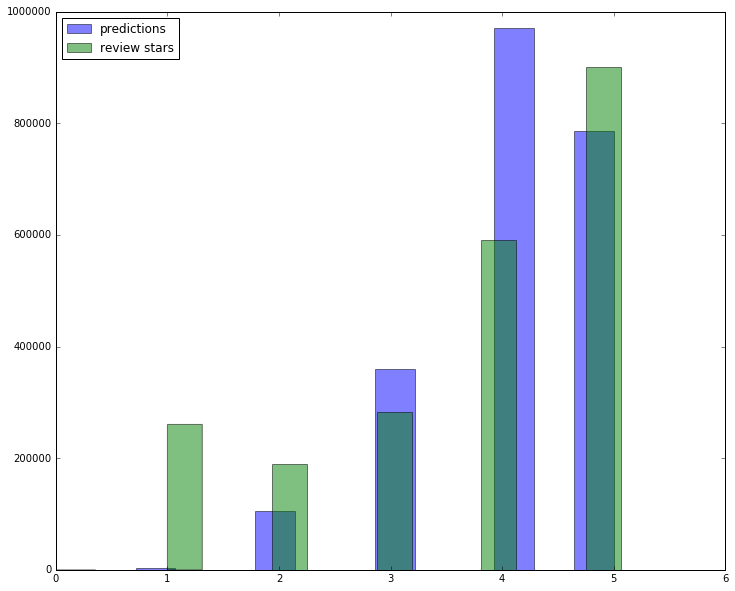

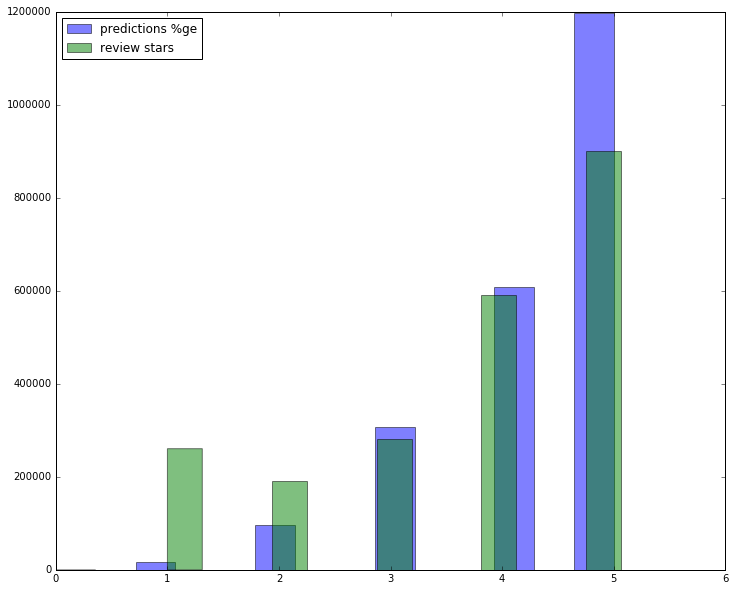

2300.95825315 sec


In [1]:
import json
import time,sys, math
import collections
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import nltk
from nltk.stem import PorterStemmer as ps
#from nltk import sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

"""
Sentimental analysis of review: Solution() class has two methods parseReviews() and getScore() to read the json file, 
get review text, stem and analyze tone and return a score. By mapping this score into range [1,5], we can get counters
for review stars and predicted stars. We can map these counts in buckets of each star as histograms for visualizing
the quality of sentimental analysis.

Drawback: Can't correctly classify mix or satirical reviews.

Overall runtime: avg of 30 min
"""
class Solution:
    def __init__(self):
        self.review_dump = collections.defaultdict(list) #key=userid, value=[reviewid,text,stars]
        self.review_stem = []
        self.review_score = collections.defaultdict(list)
        self.posDict = collections.defaultdict(str)
        self.negDict = collections.defaultdict(str)
        self.predictions = []
        self.stars = []
        self.predictions_perc = []
        self.correction = 0.2
    def parseReviews(self,path):
        #read the file line by line, load it as json and get score 
        """
        input: path of json file to be parse
        output: Counter() objects showing stars predictions and stars counted from review file
        Also plots histogram using these counters
        """
        reviewfile = open(path,"r")           
        print "open",path
        for line in reviewfile:
            #print "DEBUG", line
            temp_decode = json.loads(line)            
            score, perc = self.getScore(re.findall(r"[\w']+|[.,!?;]",temp_decode["text"],re.UNICODE))
                    
            self.predictions.append(max(1,min(5,math.ceil(score+self.correction))))
            self.stars.append(temp_decode['stars'])
            self.predictions_perc.append(perc)
            
        print "DEBUG: \tdone\n"#, self.review_dump
        reviewfile.close()
        print "pred:", Counter(self.predictions)
        print "data:",Counter(self.stars)
        print "percentages:", Counter(self.predictions_perc)
        #print self.predictions, self.stars
        
    def getScore(self, text):
        #print "DEBUG: time to stem"
        #print text
        """
        get review text as input
        return two predictive scores using two methods: 1) %ge of postive words 2) scale +ve and -ve to [1,5] stars
        """
        stemmer = ps()
        retscore = 0.0
        #stem the comment text
        self.review_stem = [stemmer.stem(w.lower()) for w in text]
        
        #get lexicon score for review_stem[] and return positive/negative
        pos = 1
        neg = 1
        for w in self.review_stem:    
            if w in "!.,;'": continue
            if self.posDict[w]:
                #retscore += 1
                pos += 1
            elif self.negDict[w]:
                #retscore -= 1
                neg += 1
        #method 1: positive word %ge 
        stars = (6*float(pos)/float(pos+neg))
        #print int(stars), stars, int(stars)*1.0 - stars
        if abs(int(stars)*1.0 - stars) > self.correction:
            stars = math.ceil(stars)
        else:
            stars = int(stars)
        perc =  int(max(1, min(5,stars)))

        #method 2: scale pos and neg to [1,5] stars
        retscore = float(pos-neg)/float(pos+neg)
        if not retscore:
            return 2.5, perc #midpoint
        
        return 2.5+2.5*retscore, perc 
    
        #propose method 3: we can also find a way to incorporate text length in the prediction,
        #high score and high review length could mean the review is very good
    
        
if __name__ == "__main__":
    starttime = time.time()
    s = Solution()
    #construct a positive word directory of 2006 words - if a word not found, consider negative
    
    posfile = open("positive-words.txt","r")
    #form dictionary of positive words for fast lookups
    for posline in posfile:
        if posline[0] == ';' or posline[0]=='\n': #header ignore and empty lines
            continue
        s.posDict[posline.split("\n")[0].lower()] = 1
            
    #form dictionary of negative words w=for fast lookups
    negfile = open("negative-words.txt","r")
    for negline in negfile:
        if negline[0] == ';' or negline[0]=='\n': #header ignore and empty lines
            continue
        s.negDict[negline.split("\n")[0].lower()] = 1    
        
    #parse file, get score and get predictions as well as actual stars into solution object s()
    s.parseReviews("yelp_academic_dataset_review.json")
    
    plt.figure(1,figsize=(12,10),dpi=80)    
    
    #first method : offset two bins for predictions and actual stars for visualizing
    bins = np.linspace(0,5,15)
    plt.hist(s.predictions, bins, alpha = 0.5, label='predictions')
    bins = np.linspace(1,6,17)
    plt.hist(s.stars, bins, alpha = 0.5, label='review stars')
    plt.legend(loc='upper left')
    #plot these 5 buckets with slight offset
    plt.show()
    
    #second method - using percentage of positive words
    plt.figure(2,figsize=(12,10),dpi=80)    
    bins = np.linspace(0,5,15)
    plt.hist(s.predictions_perc, bins, alpha = 0.5, label='predictions %ge')
    bins = np.linspace(1,6,17)    
    plt.hist(s.stars, bins, alpha = 0.5, label='review stars')
    plt.legend(loc='upper left')
    plt.show()
    
    print time.time()-starttime, "sec"

Visualization and short (detailed) analysis. **(10 pts)**

APPROACH:
To predict the stars of a review based on the text, we have to perform following two steps: 

    1) Stemming: Stemmer reduces a word to its root which makes it easier to categorize as positive or negative
        Here, we use well known porterstemmer for reducing the data
    2) Lexicon analysis:
        To get sentimental score for a comment, we can view the text as postive, negative and neutral words.
        By calculating positive and negative scores, we can map the scores in range of [1,5] to get estimated stars.
        There are many lexicons available for python libraries. But the easiest one to use is Bing Liu's Opinion Lexicon http://sentiment.christopherpotts.net/lexicons.html
        Since this doesn't need any additional installations, it's easier to just store the positive and negative lists.
        We then get the words into main memory by reading them into dictionary which gives us O(1) lookup. Therefore the score calculating routine is O(N) where N is size of total text. 

Here's some analysis of positive and negative words. I've added a few obvious missing words related to food to positive and negative such as awesome, greasy, delicious, etc.
Positive words: 2006
Negative words: 4783

SCORING:
To get the actual estimate of the stars, I have used two correlated approaches:
approach one: 
I have used positive and negative counts to plot the score in [1,5] range with positive=negative meaning 2.5 stars (i.e. 3 integer stars after taking math.ceil())
Here is the formula from the code,
        
        """
        retscore = float(pos-neg)/float(pos+neg)
        if not retscore:
            return 2.5 #midpoint        
        return 2.5+2.5*retscore
        """

approach two:         
    Scale positive and negative results in order to map the percentage of postive words in range [1,5]. This gives slightly worse results but it's expected because of the skewed data with mixed and satirical comments.
    
        """
        return int(max(0, min(5,6*float(pos)/float(pos+neg))))
        """
        
DATA SKEWS:
Another significant value is the correction factor to adjust my results. Due to some of the mix or satirical results, I was seeing the graphs slightly skewed. I had to add a correction factor of 0.2 for getting better results. The value basically stands for correcting the skewed results.

Another reason is as we can see, 1 star views are skewed the most for first diagram. This is because of the math.ceil() function wich converts 1.1 stars to 2.0. I tried to tinker with the round-off approach but couldn't get a satisfying result.

-----------------

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

Counter({9: 532, 1: 530, 3: 310, 5: 214, 15: 1})
plotting 1
plotting 3
plotting 5
plotting 9
['American/pubs', 'Chinese/kid friendly', 'Italian/outdoors', 'Mexican/pubs']


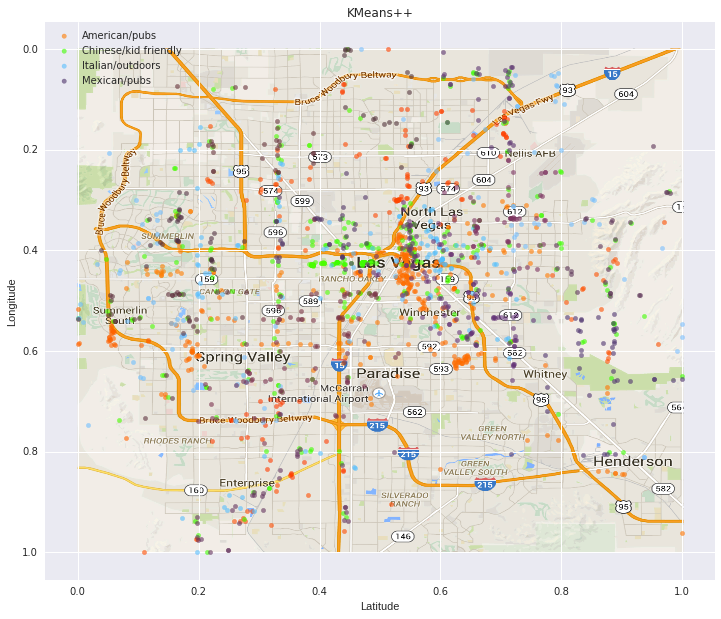

Counter({9: 532, 1: 530, 3: 310, 5: 214, 15: 1})
plotting all 1587 1587 1587


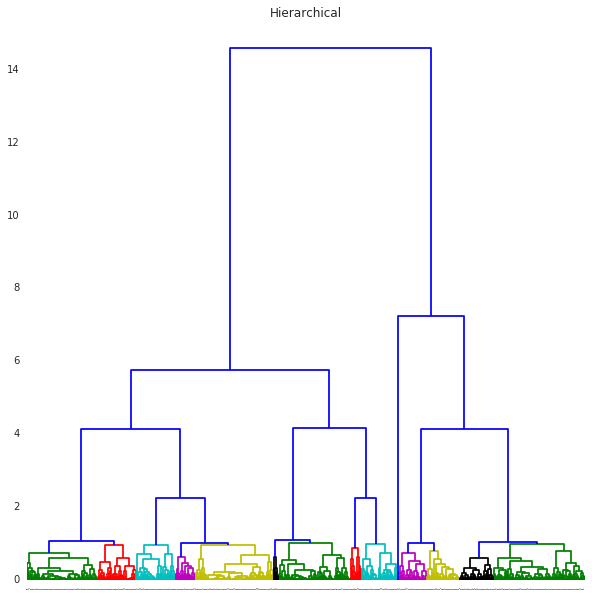

Counter({9: 532, 1: 530, 3: 310, 5: 214, 15: 1})
plotting all 1587 1587 1587


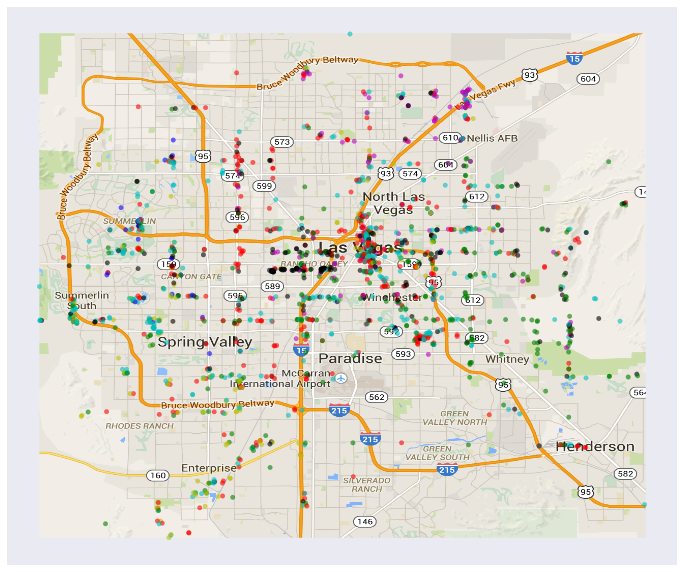

In [4]:
import json
from pprint import pprint
import numpy as np
import re
import collections
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter
from sklearn.manifold import MDS
import sklearn.metrics as metrics
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as hr
from sklearn import preprocessing as prep
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
import random
from sklearn import mixture

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.vq import kmeans,vq
from matplotlib.mlab import PCA
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture
import warnings

%matplotlib inline
"""
Culinary district clustering:
We need to run multidimentional clustering on the yelp business dataset on closeness and similarity. For closeness, 
we have latitude longitude, which we can scale in range [0,1]. This helps in clustering as well as plotting.
For similarity, we choose a few categories and attributes (possibly mutually exclusive for better visualizations)

The restaurant data can be directly fed to clustering algorithms and the clusters can be plotted as scatter plots or dendograms.
We can distringuish between the clusters based on the colors. But the disadvantage of this approach is labeling.
It's impossible to know which cluster belongs to which category. 
That's why we can first group the restaurants on category, and cluster based on closeness+attributes+categories. 
Even though the approach needs multiple iterations and gives exactly the same types of clusters, each cluster can be labeled immediately.

Overall runtime: <2 min

Functions:
parseVegas(): get all restaurants in las vegas having attributed and categories specified in attrDict{} and categDict{}

kmeansPlotVegas(): Pass the dictionary formed by parsing json, create scaled dataframe for lat, long for each attr and categ. 
Create a cluster according to attr/categ and annotate by mapping the values via getLabels()

hierarchicalPlot(): Labeling for this iteration could be done in same way as that of kmeans. So I've skipped that part and passed the entire dataframe.
 distancematrix for this dataframe, create a dendrogram.
 
GMMPlot(): Pass a similar scaled dataframe and plot.

More details in markdown and in-place comments.
"""
def randomColors(k):
    #returns some random shade of color (r,g,b) factor
    #this logic also makes sure one shade of color for one category
    #for example, american restaurants of different attributes will all have red shades because r=1 for k=1
    ret = 0.0
    if k==1:
        ret = (1,random.uniform(0.2,0.5), 0.0)
    elif k == 3:
        ret = (random.uniform(0.2,0.3),1, 0.0)
    elif k == 5:
        ret = (random.uniform(0.3,0.5), 0.75, 1)
    else:
        ret = (random.uniform(0.3,0.5),0.2, random.uniform(0.2,0.5))
    #print "colors", ret
    return ret
def getLabels(grlist):
    
    ret = []
    for groups in grlist:
        """
        Return a string label for a unique attr/category score.
        Here I have used a slightly complex approach:
        I represent the attr/categ values as a binary array. But I store the decimal values.
        I achieve this by storing a left shift of 1 by the category number, for example:
        if mexican is 3rd category and pubs is 1st attribute, (1 << 3 | 1 << 1 = 8 | 1 = 9)
        
        Also, in the legends, I chose to annotate only four out of total 12 clusters. More details in markdown.
        """
        if groups == '1':
            ret.append("American/pubs")
        if groups == '3':
            ret.append("Chinese/kid friendly")
        if groups == '5':
            ret.append("Italian/outdoors")
        if groups == '9':
            ret.append("Mexican/pubs")
    
    return ret
def kmeansPlotVegas():
    #print vegasdict
    #vegasclusters = [[] for i in range(len(vegasvq))]
    """
    Cluster and plot using kmeans. It's actually a lot easier to plot the clusters immediately after clustering.
    Instead of going to next cell, I have printed all the clusters at the end of this cell.
    """
    vegasclusters = collections.defaultdict(list)
    legends = collections.defaultdict(list)
    
    #plot overlay image and clusters
    plt.figure(1,figsize=(12,10),dpi=80)
    im = plt.imread('vegas.png')
    implot = plt.imshow(im,extent=[0,1,1,0], aspect='auto')
    
    categories = Counter(vegasdict['categ'])
    print categories
    for c,v in categories.items():
        latlist = []
        longlist = []
        
        #populate all restaurants of same categ/attr values
        for i in xrange(0, len(vegasdict['categ'])):
            if vegasdict['categ'][i] == c:            
                latlist.append(vegasdict['lat'][i])
                longlist.append(vegasdict['long'][i])
        if len(latlist)<17 or len(longlist)<17: 
            #don't plot small clusters
            continue
        print "plotting", c
        
        #create dataframe using lat, long of these attr/categ
        vegasdf = pd.DataFrame({'lat':longlist, 'long':latlist})
        vegasdf[['lat','long']] = vegasdf[['lat','long']].apply(lambda k: prep.MinMaxScaler().fit_transform(k))

        #print vegasdf
        vegasmatrix = vegasdf.as_matrix()
        #print vegasmatrix
        warnings.filterwarnings("ignore",category=DeprecationWarning)        
        kmeans=KMeans(init='k-means++',n_clusters=16, n_init=10)
        kmeans.fit_predict(vegasmatrix)
        centroids = kmeans.cluster_centers_
        vegasvq = vq(vegasmatrix, centroids)[0]
        vegasclusters[c] = [[] for i in range(len(vegasvq))]
        
        for item, clustN in zip(vegasmatrix, vegasvq):
            #store the cluster for categ/attr and cluster number
            vegasclusters[c][clustN].append(item)
        for cl in vegasclusters[c]:
            #label and give random clolor
            legends[c]=plt.scatter([item[0] for item in cl],[item[1] for item in cl],marker='o', color=randomColors(c), alpha=0.6)
            
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plots = map(lambda k:k[1], legends.items())
    
    #get all labels for clusters
    labels = getLabels(map(lambda k:str(k), legends.keys()))
    print labels
    plt.legend(plots, labels, loc='upper left')
    plt.title("KMeans++")
    plt.show()

def hierarchicalPlot():
    plt.figure(2)
    
    categories = Counter(vegasdict['categ'])
    print categories
    latlist = vegasdict['lat']
    longlist = vegasdict['long']
    categlist = vegasdict['categ']
    attrlist = vegasdict['attr']
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    print "plotting all", len(longlist), len(latlist), len(categlist)
    #create entire dataframe and scale it
    vegasdf = pd.DataFrame({'lat':longlist, 'long':latlist, 'cat':categlist, 'attr':attrlist})
    vegasdf[['lat','long']] = vegasdf[['lat','long']].apply(lambda k: prep.MinMaxScaler().fit_transform(k))
    #print vegasdf
    distancematrix=pdist(vegasdf,'euclidean')
    #print distancematrix
    Z = hr.linkage(vegasdf, method='complete', metric='euclidean')

    #cluster all the data together: by plotting everything together, we can't label it properly
    ck = hr.fcluster(hr.linkage(distancematrix, method='complete'), 1.5,'distance')
    fig=plt.figure(figsize=(10,10))
    T = hr.dendrogram(Z,color_threshold=1, leaf_font_size=1)
    
    plt.title("Hierarchical")
    plt.show()

def GMMPlot():
    plt.figure(3,figsize=(12,10),dpi=80)
    im = plt.imread('vegas.png')
    implot = plt.imshow(im,extent=[0,1,1,0], aspect='auto')    
    
    categories = Counter(vegasdict['categ'])
    print categories
    latlist = vegasdict['lat']
    longlist = vegasdict['long']
    categlist = vegasdict['categ']
    attrlist = vegasdict['attr']

    print "plotting all", len(longlist), len(latlist), len(categlist)
    #vegasdf = pd.DataFrame({'lat':longlist, 'long':latlist, 'cat':categlist, 'attr':attrlist})
    
    #this is again a similar approach as hirarchical plot but difficult to label this way
    vegasdf = pd.DataFrame({'zcat':categlist, 'zattr':attrlist, 'lat':longlist, 'long':latlist})
    vegasdf[['lat','long']] = vegasdf[['lat','long']].apply(lambda k: prep.MinMaxScaler().fit_transform(k))
    #print vegasdf
    X = vegasdf.as_matrix()
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    clf = mixture.GMM(n_components=19, covariance_type='diag')
    temp = clf.fit(X)
    #give different colors, as mentioned in the class
    colors = np.array([x for x in 'bgrcmykgrcmykgrcmykbgrcmyk'])
    
    classfit = clf.predict(X)
    plt.scatter(X[:,0],X[:,1], color = colors[classfit].tolist(), alpha=0.6)
    plt.xticks(())
    plt.yticks(())
    
    plt.show()
    
def parseVegas(path):
    """
    Read the file and Las Vegas cities that have categories and attributes from categDict{} and attrDict{}
    The dictionary has 4 lists for attr, categ, lat and long - all of same length
    therefore, it's easier to make sure ith value for each list is indeed for the same restaurant
    
    We then use the attr/categ scores to group restaurants and cluster based on closeness and eventually plot
    with labels corresponding to attr/categ score
    """
    vegasfile = open(path, "r")
    for vegasline in vegasfile:
        vegasdecode = json.loads(vegasline)
        if vegasdecode['city']== "Las Vegas":
            #print "####", filter(lambda k:k[1]==True, vegasdecode['attributes'].items()), "###"
            
            #filter out True attributes
            attrset = filter(lambda k:k[1]==True, vegasdecode['attributes'].items())
            attrnames = map(lambda k:k[0], attrset)

            attflag, categflag = False, False
            categset = vegasdecode['categories']
            #print categset
            tempattr= 1
            for attr in attrnames:
                #print attr,"!!!"                
                if attr.lower() in attrDict:
                    #print vegasdecode['attributes']
                    attflag = True
                    tempattr |= 1<< attrDict[attr.lower()]
            if attflag:
                tempcateg = 1
                for categ in categset:
                    #print categ, categ.lower() in categoryDict
                    if categ.lower().split(" ")[0] in categoryDict:
                        #print "IN", categ
                        categflag = True
                        tempcateg |= 1 << categoryDict[categ.lower().split(" ")[0]]
                if categflag:
                    #make sure ith slot of all list has the same restaurant - or else the data doesn't make any sense
                    vegasdict['attr'].append(tempattr)
                    vegasdict['categ'].append(tempcateg) 
                    vegasdict['lat'].append(vegasdecode['latitude'])
                    vegasdict['long'].append(vegasdecode['longitude'])
    #print vegasdict['lat'][0]
    #cluster using 3 methods and plot immediately
    kmeansPlotVegas()
    hierarchicalPlot()
    GMMPlot()
    
vegasdict = collections.defaultdict(list)
#change these values according by referring to json data- currently considering only one levelled data which has True
#here outdoor seating has slot two.. so while calculating attribute score, we will use 1 << 2 = 4. This ensures unique score for each categ/attr combination
attrDict = {"good for kids":0, "pubs":1, "outdoor seating":2}                
categoryDict = {'american':0, 'chinese':1, 'italian':2, 'mexican':3}

parseVegas("yelp_academic_dataset_business.json")


Visualize your clusters using each technique. Label your clusters. **(10 pts)**

### Visualization and explanations:
### Done along with clustering in previous cell. I've labelled kmeans clusters. Same approach can be taken to label other two clusters.

PARSING:
We need to run multidimentional clustering on the yelp business dataset on closeness and similarity. For closeness, 
we have latitude longitude, which we can scale in range [0,1]. This helps in clustering as well as plotting.
For similarity, we choose a few categories and attributes (possibly mutually exclusive for better visualizations)

The restaurant data can be directly fed to clustering algorithms and the clusters can be plotted as scatter plots or dendograms.

INPUT PARAMETERS:
Included in cluster comparisons at the end.

OUTPUT:
The output is three plots using these three clustering techniques. As we can see, some of the clusters are overlapping. This can be understood because two nearby restaurants can belong to separate attr/categ pair. Therefore, the closeby restaurants will be included in separate clusters. More details on different output in cluster comparison section.

LABELING:
We can distringuish between the clusters based on the colors. But the disadvantage of this approach is labeling.
It's impossible to know which cluster belongs to which category. 
That's why we can first group the restaurants on category, and cluster based on closeness+attributes+categories. 
Even though the approach needs multiple iterations and gives exactly the same types of clusters, each cluster can be labeled immediately.

More details in commented code and cluster comparisons below.


Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

In [ ]:
"""
In the cluster, easiest way to identify an outlier is the point farthest away in the cluster. 
By extending this notion, we can calculate the distance of each point from the centroid for kmeans and output the farthest few points
For hierarchical clustering, outliers don't affect the output and are considered as separate clusters. 
Because here the clustering parameter is linkage factor.
GMM also scales pretty well for non-spherical outlier data and divides the outliers into separate clusters.
"""


Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

## Comparison between kmeans, hierarchical and GMM clustering:
#### Inputs Parameters: 
1) KMeans:
 K - number of clusters:
 Number of clusters should be selected with starting points such that the Euclidean distance is minimized between centroid and all the points in the cluster. Also, using the data we have, the attr/categ combination can give us (4 categ)*(3 attr) = 12 types of clusters. Depending on the closeness, these clusters will be eventually divided further. So we now know K>12.
 Using the distance formula for few data points in kmeanspp.pdf lecture notes and running clustering a few times, I decided on K=16.
 Initial points:
 Since we are using kmeans++, we only supply initial number of points as 10 and the algorithm randomly distributes them for better results. 
 
2) Hierarchical:
Linkage criteria: Average linkage minimizes the average of the distances between all observations of pairs of clusters. This decides how many clusters are present in the data. We don't need to specify any estimated number, number of iterations or initial points.

3) GMM:
This algorithm will always use all the components it has access to, needing held-out data or information theoretical criteria to decide how many components to use
I used similar approach to KMeans clustering in order to define the number of components. But the BIC criterion can be used to select the number of components in a GMM in an efficient way. 


#### Calculations and Output:
1) KMeans: The algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose k samples from the dataset X. After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold.

2) Hierarchical:
build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. 

3) GMM:
Considers non-spherical clusters and implements the expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models. 


#### Advantages and disadvantages: Performance, initial parameters, labeling
1) KMeans:
suffers from local minima Given enough time, K-means will always converge, however this may be to a local minimum.  
Considers spherical clusters
Outliers affect the centroid calculation, and therefore the whole cluster

2) Hierachical: No assumption on number of clusters
performance

3) GMM: the fastest algorithm for learning mixture models
as this algorithm maximizes only the likelihood, it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply.
The main difficulty in learning Gaussian mixture models from unlabeled data is that it is one usually doesn’t know which points came from which latent component


#### References: 
Lecture slides, sklearn user's manual.


In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()